In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [9, 9]
mpl.rcParams['font.size'] = 27

mpl.rcParams['savefig.dpi'] = 150 
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 10 
mpl.rcParams['xtick.minor.size'] = 5 

mpl.rcParams['ytick.major.size'] = 10 
mpl.rcParams['ytick.minor.size'] = 5 

mpl.rcParams['xtick.labelsize'] = 23
mpl.rcParams['ytick.labelsize'] = 23

In [44]:
GC_name = 'NGC3201'
data_path = os.getcwd()
fidanka = pd.read_csv('fiducial_lines.csv')

In [45]:
df = pd.read_csv(GC_name + '_fitstars_DRCR.dat')

In [46]:
from scipy.interpolate import CubicSpline
ff = CubicSpline(fidanka['v'],fidanka['vi'])

In [47]:
AS_df = pd.read_csv("{}artstars.dat".format(GC_name),sep='\s+')
AS_df = AS_df[((AS_df['#InputX'] - AS_df['OutputX'])**2 + (AS_df['InputY'] - AS_df['OutputY'])**2 <= 0.25) & (np.abs(AS_df['InputF606W'] - AS_df['OutputF606W']) <= 0.75) & (np.abs(AS_df['InputF814W'] - AS_df['OutputF814W']) <= 0.75)]
V_diff=31.4
VI_diff=0.897
I_diff = V_diff - VI_diff
AS_df_CR = AS_df.copy()
AS_df_CR['InputF606W'] += V_diff
AS_df_CR['OutputF606W'] += V_diff
AS_df_CR['InputF814W'] += I_diff
AS_df_CR['OutputF814W'] += I_diff
AS_df_CR['AR_cdiff'] = (AS_df_CR['OutputF606W'] - AS_df_CR['OutputF814W']) - (AS_df_CR['InputF606W'] - AS_df_CR['InputF814W'])
df['Obs_cdiff'] = df['vi'] - ff(df['v'])

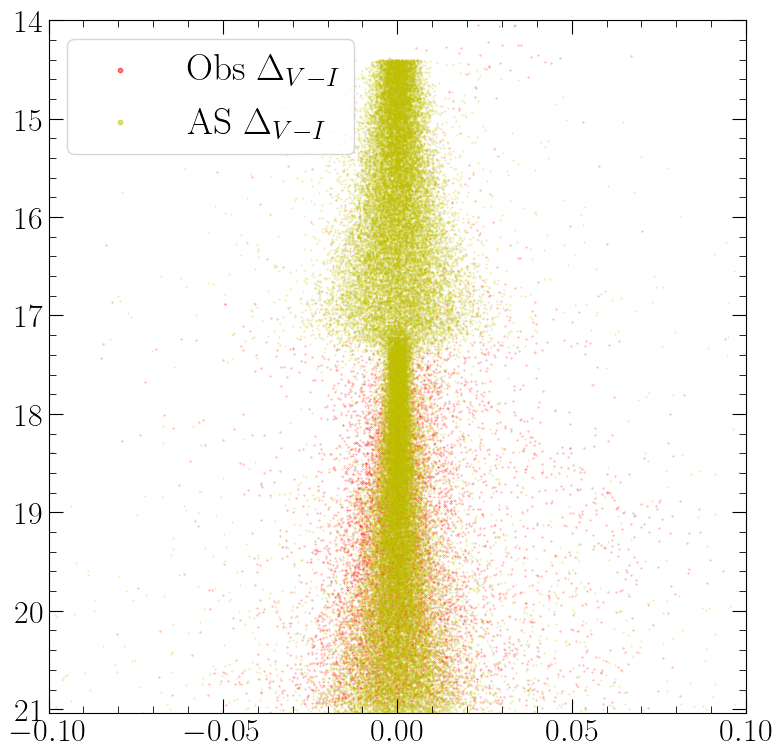

In [48]:
plt.scatter(df['Obs_cdiff'],df['v'],s=0.1,alpha=0.5,c='r',label=r'Obs $\Delta_{V-I}$')
plt.scatter(AS_df_CR['AR_cdiff'], AS_df_CR['InputF606W'],s=0.1,alpha=0.5,c='y',label=r'AS $\Delta_{V-I}$')
plt.ylim(np.max(df['v']),np.min(df['v']))
plt.xlim(-0.1,0.1)
plt.legend(markerscale=10);

In [49]:
AS_df_CR = AS_df_CR[np.abs(AS_df_CR['AR_cdiff']) < 0.08]

In [50]:
from scipy.stats import median_abs_deviation
df['MAD'] = np.concatenate((np.zeros(50),np.array([median_abs_deviation(df['Obs_cdiff'].values[i:i+100]) for i in range(50)]),np.array([median_abs_deviation(df['Obs_cdiff'].values[i:i+200]) for i in range(len(df) - 200)]),np.zeros(100)))
AS_df_CR['MAD'] = np.concatenate((np.zeros(500),np.array([median_abs_deviation(AS_df_CR['AR_cdiff'].values[i:i+1000]) for i in range(len(AS_df_CR) - 1000)]),np.zeros(500)))

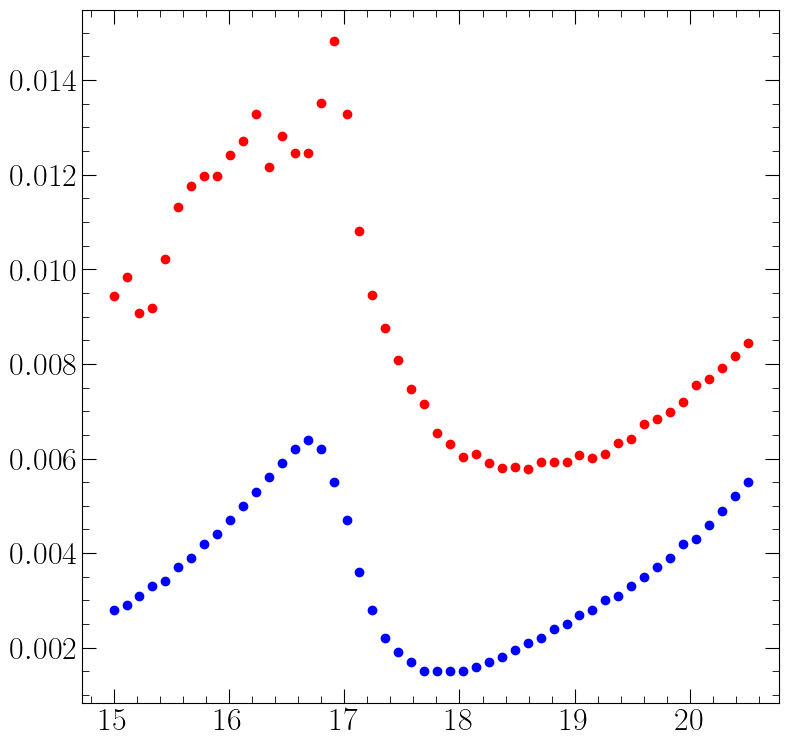

In [51]:
for max_v in np.linspace(15.5,21,50):
    min_v = max_v - 1
    art_in_range = AS_df_CR[(AS_df_CR['InputF606W'] < max_v) & (AS_df_CR['InputF606W'] > min_v) & (AS_df_CR['AR_cdiff'] > -0.05) & (AS_df_CR['AR_cdiff'] < 0.05)]['AR_cdiff'].values
    obs_in_range = df[(df['v'] < max_v) & (df['v'] > min_v)]['Obs_cdiff'].values
    plt.scatter(max_v-0.5, median_abs_deviation(art_in_range),c='b')
    plt.scatter(max_v-0.5, median_abs_deviation(obs_in_range),c='r')

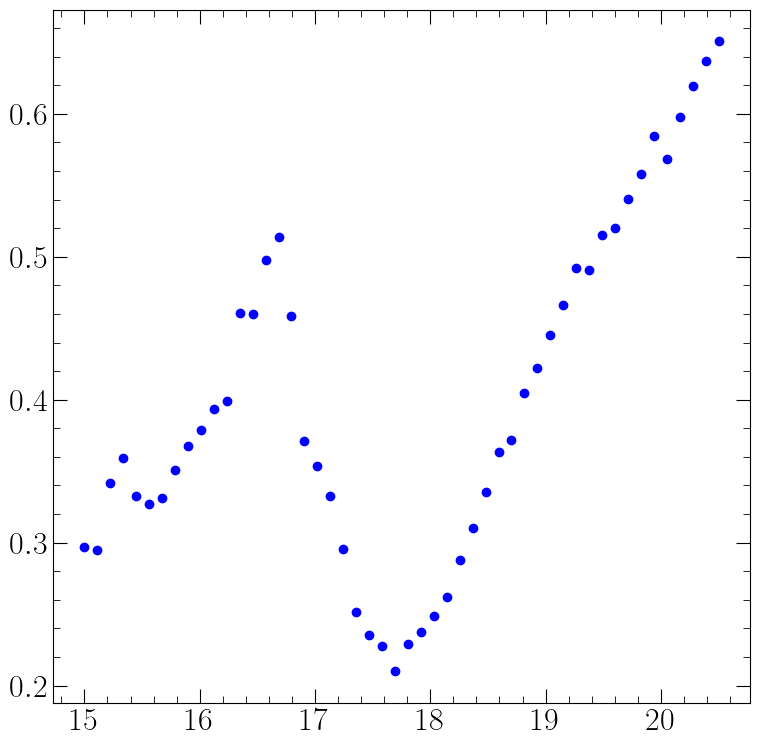

In [52]:
mag_bin = []
ratio = []
for max_v in np.linspace(15.5,21,50):
    min_v = max_v - 1
    art_in_range = AS_df_CR[(AS_df_CR['InputF606W'] < max_v) & (AS_df_CR['InputF606W'] > min_v) & (AS_df_CR['AR_cdiff'] > -0.05) & (AS_df_CR['AR_cdiff'] < 0.05)]['AR_cdiff'].values
    obs_in_range = df[(df['v'] < max_v) & (df['v'] > min_v)]['Obs_cdiff'].values
    mag_bin.append(max_v-0.5)
    ratio.append(median_abs_deviation(art_in_range)/median_abs_deviation(obs_in_range))
    plt.scatter(max_v-0.5, median_abs_deviation(art_in_range)/median_abs_deviation(obs_in_range),c='b')

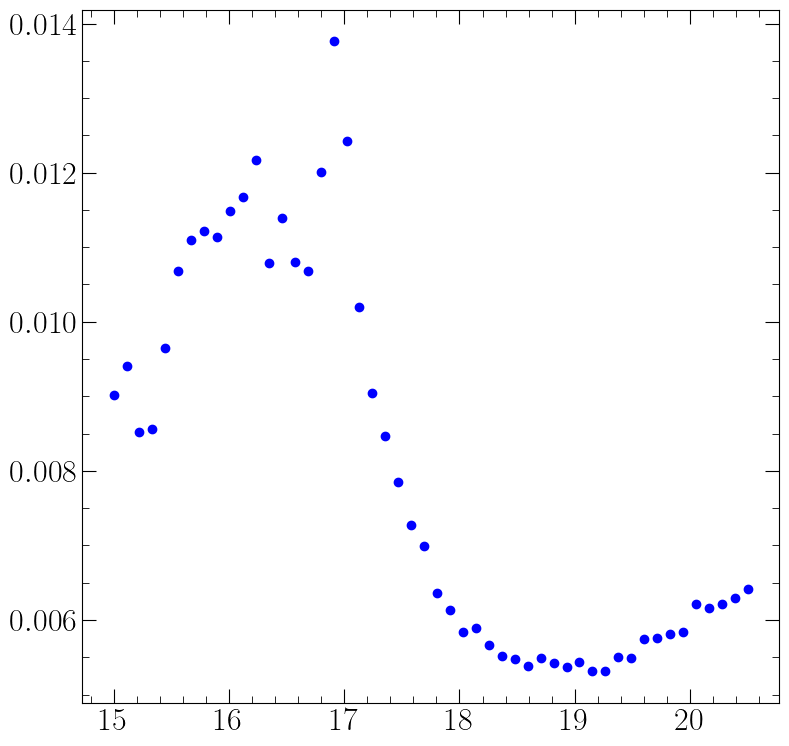

In [39]:
mag_bin = []
diff = []
for max_v in np.linspace(15.5,21,50):
    min_v = max_v - 1
    art_in_range = AS_df_CR[(AS_df_CR['InputF606W'] < max_v) & (AS_df_CR['InputF606W'] > min_v) & (AS_df_CR['AR_cdiff'] > -0.05) & (AS_df_CR['AR_cdiff'] < 0.05)]['AR_cdiff'].values
    obs_in_range = df[(df['v'] < max_v) & (df['v'] > min_v)]['Obs_cdiff'].values
    mag_bin.append(max_v-0.5)
    diff.append(np.sqrt(np.abs(median_abs_deviation(art_in_range)**2 - median_abs_deviation(obs_in_range)**2)))
plt.scatter(mag_bin, diff,c='b')

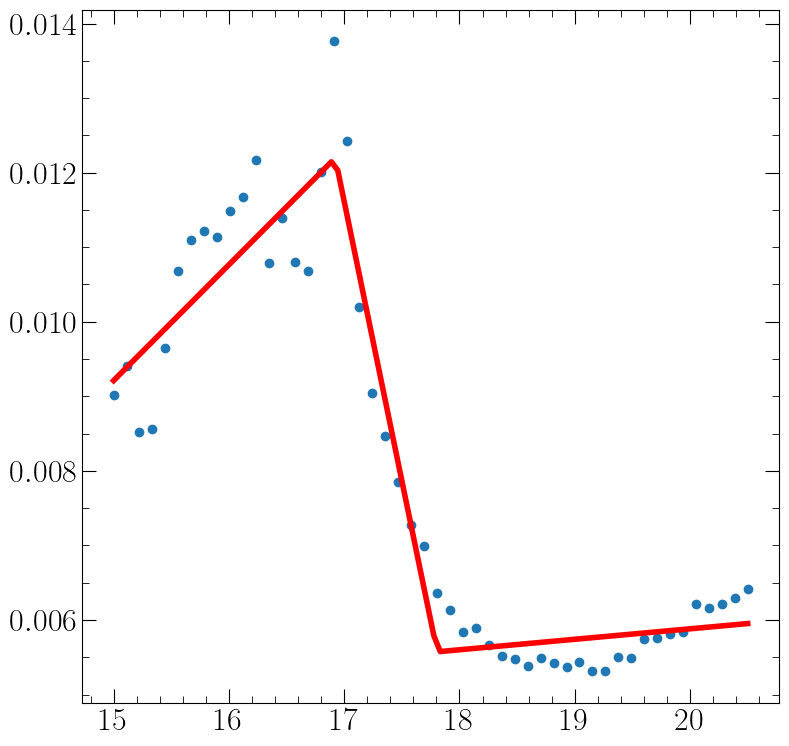

In [56]:
import piecewise_regression
pw_fit = piecewise_regression.Fit(mag_bin, diff, n_breakpoints=2)
pw_fit.plot_fit(color="red", linewidth=4)
plt.scatter(mag_bin,diff)

In [57]:
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                       50
No. Model Parameters                    6
Degrees of Freedom                     44
Res. Sum of Squares           1.65313e-05
Total Sum of Squares          0.000325719
R Squared                        0.949247
Adjusted R Squared               0.942165
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const             -0.0140925      0.00482      -2.9243       0.00544    -0.023805   -0.0043803
alpha1            0.00155356     0.000304       5.1098       6.7e-06   0.00094082    0.0021663
beta1            -0.00904474     0.000785      -11.522             -    -0.010627   -0.0074626
beta2             0.00763173      0.00074       10.309             -    0.0061398    0.0091236
breakpoint1      

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       50\nNo. Model Parameters                    6\nDegrees of Freedom                     44\nRes. Sum of Squares           1.65313e-05\nTotal Sum of Squares          0.000325719\nR Squared                        0.949247\nAdjusted R Squared               0.942165\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst             -0.0140925      0.00482      -2.9243       0.00544    -0.023

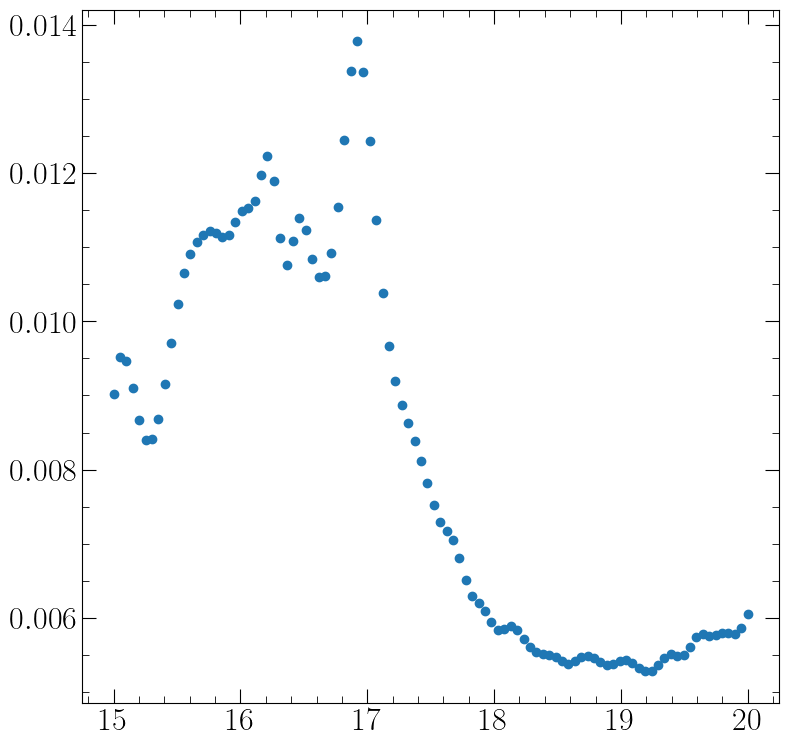

In [53]:
from scipy.interpolate import splrep, BSpline
spl = splrep(mag_bin,diff)
plt.scatter(np.linspace(15,20,100),BSpline(*spl)(np.linspace(15,20,100)))

In [54]:
mag_bin

[15.0,
 15.112244897959183,
 15.224489795918368,
 15.33673469387755,
 15.448979591836734,
 15.561224489795919,
 15.673469387755102,
 15.785714285714285,
 15.897959183673468,
 16.010204081632654,
 16.122448979591837,
 16.23469387755102,
 16.346938775510203,
 16.459183673469386,
 16.571428571428573,
 16.683673469387756,
 16.79591836734694,
 16.908163265306122,
 17.020408163265305,
 17.132653061224488,
 17.244897959183675,
 17.357142857142858,
 17.46938775510204,
 17.581632653061224,
 17.693877551020407,
 17.806122448979593,
 17.918367346938776,
 18.03061224489796,
 18.142857142857142,
 18.255102040816325,
 18.367346938775512,
 18.479591836734695,
 18.591836734693878,
 18.70408163265306,
 18.816326530612244,
 18.928571428571427,
 19.04081632653061,
 19.153061224489797,
 19.26530612244898,
 19.377551020408163,
 19.489795918367346,
 19.60204081632653,
 19.714285714285715,
 19.8265306122449,
 19.93877551020408,
 20.051020408163264,
 20.163265306122447,
 20.275510204081634,
 20.38775510204081